In [45]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

import tensorflow.compat.v2 as tf #tf2.0
tf.enable_v2_behavior()

import tensorflow_probability as tfp
tfb=tfp.bijectors #写像
tfd=tfp.distributions #多変量正規分布
tfk=tfp.math.psd_kernels #半正定値カーネル

%pylab inline
from mpl_toolkits.mplot3d import Axes3D
rcParams['figure.figsize'] = 18,6

Populating the interactive namespace from numpy and matplotlib


In [17]:
#正弦波曲線
def sinusoid(x):
    """正弦波曲線に従うデータを生成

        Args:
            x (ndarray[..., 1]): 入力データxの...×1配列

        Returns:
            array[float]: 正弦波曲線に従うデータ
        """
    return np.sin(3*np.pi*x[..., 0]) #radian

In [18]:
def gen_dat(num_training_points, obs_noise_var):
    """データ点に合わせた正弦波曲線+正規分布に従うノイズに従うデータを生成

        Args:
            num_training_points (int): データ点のN数
            obs_noise_var (float): 正規分布に従うノイズの分散

        Returns:
            array[float]: 正弦波曲線+正規分布に従うノイズの生成データ
            array[float]: 正弦波曲線+正規分布に従うノイズの生成データ
        """
    index_points_ = np.random.uniform(-1., 1., (num_training_points, 1)) #m*1行列
    index_points_ = index_points_.astype(np.float64)
    nosie_var_ = np.random.normal(loc=0, scale=np.sqrt(obs_noise_var), size=(num_training_points)) #m行ベクトル
    # y=f(x)+noise
    obs_ = (sinusoid(index_points_))+nosie_var_
    return index_points_, obs_

In [27]:
#np.random.uniform(-1., 1., (100,1)).shape
num_training_points=100
obs_noise_var=0.1
x, y = gen_dat(num_training_points, obs_noise_var)

In [28]:
x.shape

(100, 1)

In [29]:
x[0]

array([-0.90220395])

In [30]:
y.shape

(100,)

In [31]:
y[0]

-0.9447718270730223

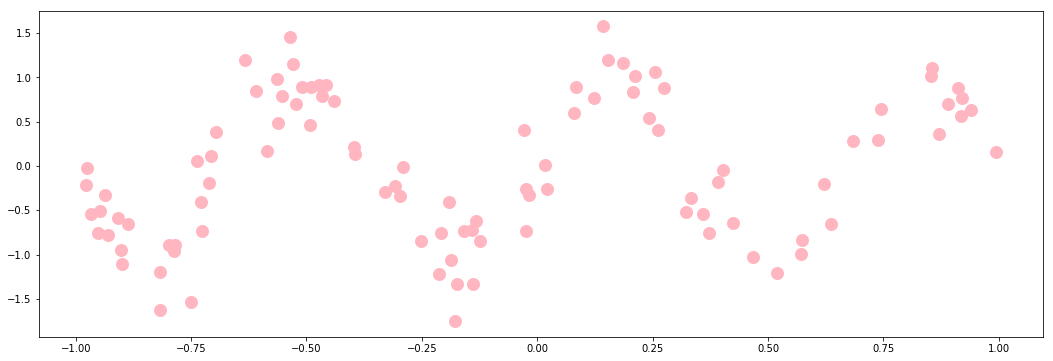

In [46]:
plt.scatter(x, y, c="lightpink", linewidths=7)

## #00 Model

In [67]:
#カーネルの設計
def set_kernel(shinpuku, hachou):
    kernel = tfk.ExponentiatedQuadratic(shinpuku, hachou)
    return kernel

In [68]:
#モデルの設計
def build_gpr(shinpuku, hachou, obs_noise_var):
    # f∼𝖬𝗎𝗅𝗍𝗂𝗏𝖺𝗋𝗂𝖺𝗍𝖾𝖭𝗈𝗋𝗆𝖺𝗅(loc=0, scale=K)
    # yi~𝖭𝗈𝗋𝗆𝖺𝗅(loc=fi, scale=σ)
    kernel = tfk.ExponentiatedQuadratic(shinpuku, hachou)
    gpr_model=tfd.GaussianProcess(kernel, index_points=x, observation_noise_variance=obs_noise_var)
    return gpr_model

## #01 Marginalized with prior

In [71]:
#事後分布=条件付き分布+事前分布のパラメータ推定
joint_prob=tfd.JointDistributionNamed({
    "shinpuku": tfd.LogNormal(loc=0., scale=np.float64(1.)),
    "hachou": tfd.LogNormal(loc=0., scale=np.float64(1.)),
    "obs_noise_var": tfd.LogNormal(loc=0., scale=np.float64(1.)),
    "obs": build_gpr
})

In [74]:
#パラメータ推定の結果
sample=joint_prob.sample()
sample

{'shinpuku': <tf.Tensor: shape=(), dtype=float64, numpy=0.18444917792532498>,
 'obs_noise_var': <tf.Tensor: shape=(), dtype=float64, numpy=2.906323948443197>,
 'hachou': <tf.Tensor: shape=(), dtype=float64, numpy=0.8605113647546708>,
 'obs': <tf.Tensor: shape=(100,), dtype=float64, numpy=
 array([-2.18828986, -0.58758366, -1.7601282 , -3.08065837,  4.06044556,
         0.14397404, -0.6593578 ,  0.09029075,  0.13217177, -0.42711383,
        -0.67340076, -0.28033322,  1.52490935, -0.59398751,  2.71178091,
        -2.25219588, -2.63301745, -0.99779092, -0.44003701, -2.46629477,
        -4.90280842, -2.57015335,  1.22293649,  2.53750712, -2.06175238,
        -1.01335445,  0.70646715, -0.32012163, -0.18882546, -1.32038582,
        -0.80462785, -0.74499069, -2.28540663,  0.90034165,  2.06673814,
        -0.94490484, -1.54720726,  5.1442289 , -2.40620383, -0.9739493 ,
        -0.32170992,  1.60031717,  1.54203003,  4.3663014 , -0.12701019,
         1.63756734, -1.98167472, -0.08811757,  0.069

In [81]:
y_sample = sample["obs"]
y_sample[:5]

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([-2.18828986, -0.58758366, -1.7601282 , -3.08065837,  4.06044556])>

In [82]:
log_joint_prob=joint_prob.log_prob(sample)
log_joint_prob

<tf.Tensor: shape=(), dtype=float64, numpy=-206.19873874905866>

## #02 Optimization
### 勾配降下法: オンライン学習

In [92]:
constrain_positive=tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

shinpuku_var=tfp.util.TransformedVariable(initial_value=1., bijector=constrain_positive, name="shinpuku", dtype=np.float64)
hachou_var=tfp.util.TransformedVariable(initial_value=1., bijector=constrain_positive, name="hachou", dtype=np.float64)
obs_noise_var_var=tfp.util.TransformedVariable(initial_value=1., bijector=constrain_positive, name="obs_noise_var_var", dtype=np.float64)
variables=list([shinpuku_var, hachou_var, obs_noise_var_var])

trainable_variables=[var.trainable_variables[0] for var in variables]

In [115]:
@tf.function(autograph=False, experimental_compile=False)
def target_log_prob(shinpuku, hachou, obs_noise_var):
    target=joint_prob.log_prob({
        "shinpuku": shinpuku,
        "hachou": hachou,
        "obs_noise_var": obs_noise_var,
        "obs": y
    })
    return target

In [110]:
# optimize params
num_iters=500
optimizer=tf.optimizers.Adam(learning_rate=.1)

likelihood_=np.zeros(num_iters, np.float64)
likelihood_.shape

(500,)

In [116]:
# 自動微分と勾配テープ
for i in range(num_iters):
    with tf.GradientTape() as tape:
        loss_fn = -target_log_prob(shinpuku_var, hachou_var, obs_noise_var_var)
    grad=tape.gradient(loss_fn, trainable_variables)
    optimizer.apply_gradients(zip(grad, trainable_variables))
    likelihood_[i]=loss_fn

In [118]:
likelihood_[:10]

array([129.29233511, 127.09481666, 125.2236794 , 123.72052122,
       122.61731298, 121.90446879, 121.47922322, 121.11874189,
       120.55059511, 119.4402189 ])

In [125]:
print("shinpuku_var:", shinpuku_var._value().numpy()) #, hachou_var, obs_noise_var_var
print("hachou_var:", hachou_var._value().numpy()) 
print("obs_noise_var_var:", obs_noise_var_var._value().numpy()) 

shinpuku_var: 0.7665292487743883
hachou_var: 0.14805276133072906
obs_noise_var_var: 0.11049759047843148


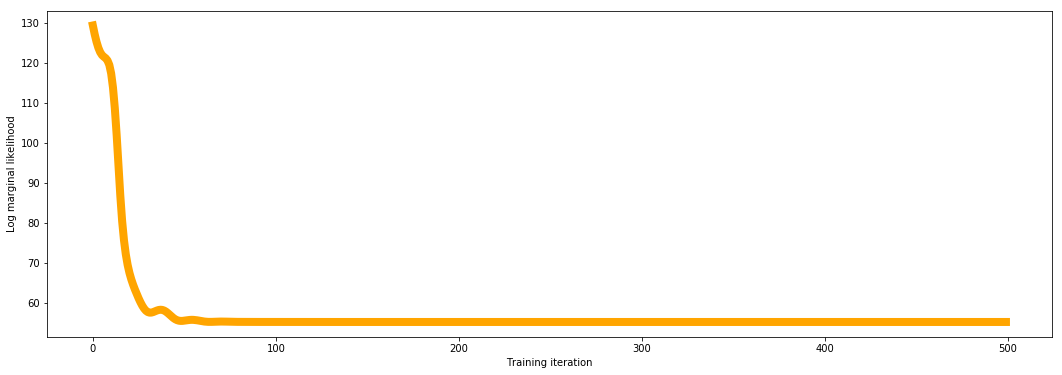

In [130]:
# Plot the loss evolution
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

plt.plot(likelihood_, color="orange", linewidth=8)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

## #04 Prediction

In [161]:
pred_x=np.linspace(-1.3, 1.3, 200, dtype=np.float64)
pred_x.shape #ベクトル

(200,)

In [162]:
pred_x=pred_x[..., np.newaxis]
pred_x.shape #行列

(200, 1)

In [163]:
pred_x[:5]

array([[-1.3       ],
       [-1.28693467],
       [-1.27386935],
       [-1.26080402],
       [-1.24773869]])

In [164]:
optimized_kernel=tfk.ExponentiatedQuadratic(shinpuku_var, hachou_var)
optimized_kernel

<tfp.math.psd_kernels.ExponentiatedQuadratic 'ExponentiatedQuadratic' batch_shape=() feature_ndims=1 dtype=float64>

In [165]:
pred_gpr=tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=pred_x,
    observation_index_points=x,
    observations=y,
    observation_noise_variance=obs_noise_var_var,
    predictive_noise_variance=0.1
)

In [166]:
num_samples=300
samples_pred=pred_gpr.sample(num_samples)
samples_pred.shape

TensorShape([300, 200])

In [167]:
samples_pred[:5,:5]

<tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[ 2.21795082,  1.86469009,  1.8118448 ,  1.68617973,  1.58360102],
       [ 0.57260307,  0.24384078,  0.50594314,  0.52438006, -0.08618766],
       [ 0.41082332,  1.0238264 ,  0.41150176,  1.04310241,  0.9400623 ],
       [-1.89947766, -1.40545893, -2.34788123, -2.55708273, -1.42479645],
       [ 0.53587173,  0.85305227,  0.74956304,  0.59407697,  0.59975054]])>

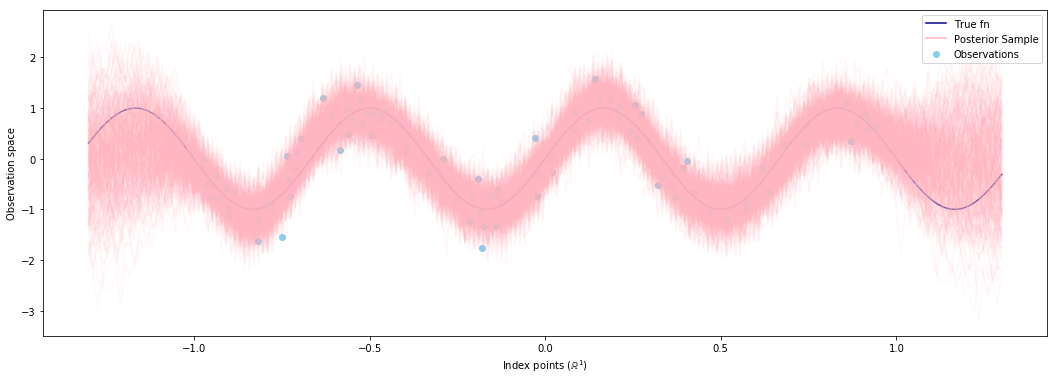

In [174]:
# Plot the true function, observations, and posterior samples.

plt.plot(pred_x, sinusoid(pred_x), label='True fn', c="darkblue")
plt.scatter(x[:, 0], y, label='Observations', c="skyblue")

for i in range(num_samples):
    plt.plot(pred_x, samples_pred[i, :], c='lightpink', alpha=.1, label='Posterior Sample' if i == 0 else None)
    
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
rcParams['figure.figsize'] = 18,6
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()